In [1]:
import os.path

import filehandling
import pandas as pd
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [2]:
def get_delaunay_vectors(points):
    tri = spatial.Delaunay(points[['x', 'y']])
    triangles = tri.points[tri.simplices]
    vecs = np.array([t-t[[2, 0, 1], :] for t in triangles])
    vecs = vecs.reshape((-1, 2))
    return vecs

def get_delaunay_angles(vecs):
    return np.arctan(vecs[:, 1]/vecs[:, 0])


def get_delaunay_lengths(vecs):
    lengths = np.linalg.norm(vecs, axis=1)
    return lengths

def calculate_G(length, angle):
    a = angle + np.pi/2
    cosa = np.cos(a)
    sina = np.sin(a)
    l = 4 * np.pi / (length * np.sqrt(3))
    return np.array((cosa, sina))*l

In [3]:
def calculate_torder_from_length_and_angle(length, angle):
    G = calculate_G(length, angle)
    return np.exp(1j*frame[['x', 'y']].values@G)

In [4]:
def get_initial_length_and_angle(frame, apothem=False):
    vecs = get_delaunay_vectors(frame)
    angles = get_delaunay_angles(vecs)
    if apothem:
        angle = np.median(angles[angles>0])
    else:
        angle = np.median(angles[angles>0.5])
    lengths = get_delaunay_lengths(vecs)
    length = np.median(lengths)
    return length, angle
        

### Minimising the std in the translational order parameter gives a much better result

In [5]:
direc = "/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/1,93mm/80%"
data_files = filehandling.list_files(f'{direc}/*.hdf5')

In [6]:
def get_frame(file):
    data = pd.read_hdf(file)
    return data.loc[0].copy()

file = data_files[1]
frame =get_frame(file)


In [7]:
def torder_angle_std(l, a):
    G = calculate_G(l, a)
    torder = np.exp(1j*frame[['x', 'y']].values@G)
    angles = np.angle(torder)
    std = np.std(angles)
    return std

torder_angle_std_vect = np.vectorize(torder_angle_std)

def refine_l_and_a(l, a, plot=False, width=0.05):
    lengths = np.linspace((1-width)*l, (1+width)*l, 100)
    angles = np.linspace((1-width)*a, (1+width)*a, 100)
    lengths, angles = np.meshgrid(lengths, angles)
    stds = torder_angle_std_vect(lengths, angles)
    min_index = np.unravel_index(np.argmin(stds, axis=None), stds.shape)
    new_length = lengths[min_index]
    new_angle = angles[min_index]
    
    if plot:
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(stds)
        plt.axvline(min_index[1], c='red')
        plt.axhline(min_index[0], c='red')
        plt.subplot(1, 3, 2)
        plt.plot(lengths[min_index[0], :], stds[min_index[0], :])
        plt.axvline(l, c='red')
        plt.axvline(new_length, c='green')
        plt.xlabel('Length [pix]')
        plt.subplot(1, 3, 3)
        plt.plot(angles[:, min_index[1]], stds[:, min_index[1]])
        plt.axvline(a, c='red')
        plt.axvline(new_angle, c='green')
        plt.xlabel('Angle [rad]')
        
        
    return new_length, new_angle
    

In [8]:
length, angle = get_initial_length_and_angle(frame, apothem=False)
initial_torder = calculate_torder_from_length_and_angle(length, angle)

In [9]:
length2, angle2 = refine_l_and_a(length, angle, True, width=0.1)
refined_torder = calculate_torder_from_length_and_angle(length2, angle2)

In [22]:
length2, angle2 = refine_l_and_a(length2, angle2, True, width=0.02)
refined_torder = calculate_torder_from_length_and_angle(length2, angle2)

In [23]:
length2, angle2

(20.225023697995976, 1.0660379666290039)

In [493]:
from pathlib import Path

In [494]:
path = Path(direc)

In [502]:
parent = path.parent

In [505]:
np.savetxt(str(parent)+'/G_length.txt', [length2])

In [507]:
np.savetxt(str(parent)+'/G_angle.txt', [angle2])

In [10]:
plt.figure()
plt.subplot(1, 2, 1)
plt.quiver(frame.x, frame.y, initial_torder.real, initial_torder.imag, np.angle(initial_torder), cmap='hsv')
plt.title('Intial guess')
plt.subplot(1, 2, 2)
plt.quiver(frame.x, frame.y, refined_torder.real, refined_torder.imag, np.angle(refined_torder), cmap='hsv')
plt.title('Refined guess')

Text(0.5, 1.0, 'Refined guess')

### Load the values for angle and length from file

In [11]:
length2 = float(np.loadtxt(str(parent)+'/G_length.txt'))
angle2 = float(np.loadtxt(str(parent)+'/G_angle.txt'))

NameError: name 'parent' is not defined

In [12]:
length2, angle2

(20.32102684859296, 1.0739238317888027)

### Add torder to the files

In [11]:
def get_torder(df, l, a):
    G = calculate_G(l, a)
    return np.exp(1j*df[['x', 'y']].values@G)

def add_torder_to_file(file):
    data = pd.read_hdf(file)
    data['torder'] = get_torder(data, length2, angle2)
    data.to_hdf(file, 'data')

for file in data_files:
    add_torder_to_file(file)

### Use the refined values to plot the susceptibility

In [451]:
def get_sus(df):
    means_t = df.groupby('frame').apply(mean_frame_values, 'torder')
    sus_t = np.mean(means_t * np.conj(means_t)) - np.mean(means_t)*np.conj(np.mean(means_t))
    means_h = df.groupby('frame').apply(mean_frame_values, 'hexatic_order')
    sus_h = np.mean(means_h * np.conj(means_h)) - np.mean(means_h)*np.conj(np.mean(means_h))
    return sus_h, sus_t

In [426]:
def mean_frame_values(points, param):
    vals = points[param].values
    return np.mean(vals)

In [452]:
duties = []
suses_h = []
suses_t = []
for file in data_files:
    data = pd.read_hdf(file)
    data['torder'] = get_torder(data, length2, angle2)
    duty = int(file[-8:-5])
    print(duty)
    sus_h, sus_t = get_sus(data)
    duties.append(duty)
    suses_h.append(sus_h)
    suses_t.append(sus_t)

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550


In [408]:
np.savetxt(direc+'/duties.txt', duties)
np.savetxt(direc+'/suses_h.txt', suses_h)
np.savetxt(direc+'/suses_t.txt', suses_t)

/home/ppxjd3/miniconda3/envs/ExperimentsNew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


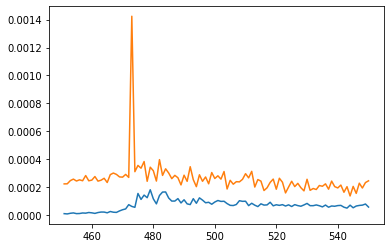

In [409]:
plt.plot(duties, suses_h)
plt.plot(duties, suses_t)

### Try just plotting the mean order

In [25]:
from tqdm import tqdm

In [26]:
duties = []
horder = []
torder = []
for file in tqdm(data_files):
    data = pd.read_hdf(file)
    data['torder'] = get_torder(data, length, angle)
    duty = int(file[-8:-5])
    h = np.abs(np.mean(data.hexatic_order))
    t = np.abs(np.mean(data.torder))
    horder.append(h)
    torder.append(t)
    duties.append(duty)

100%|██████████| 150/150 [01:04<00:00,  2.32it/s]


In [27]:
np.savetxt(direc+'/horder_mean.txt', horder)
np.savetxt(direc+'/torder_mean.txt', torder)

In [29]:
plt.plot(duties, horder)
plt.plot(duties, torder)
plt.xlabel('Density')
plt.ylabel('Mean order')
plt.legend(['Hexatic', 'Translational'])
plt.title(direc.split('NewPlate/')[1])
plt.savefig(direc+'/mean_order_plot_unrefined.png', dpi=300)